In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/Interview_Assignments/assignment.csv')

In [4]:
df.head()

,user_id,timestamp,purchase_value
0,f348dcc1ecdd88dd269eabf86dd2dd65e92ca69e841951...,2022-11-07 02:57:17.727,1274.0
1,815bcad338795606138d9fb381d25f8ebd091259768bfa...,2022-11-07 02:46:43.512,450.0
2,a1924cc344555547f1946439d01b6019f2af5498f94783...,2022-11-07 03:10:36.281,315.0
3,71ee931ac0da08c5883aecdb1c923fac63000e07a9861e...,2022-11-07 03:03:00.358,380.0
4,2036303e0d5b45e631c2307e775cc5e97258403a1f0cd0...,2022-11-07 02:47:25.242,161.0


### Business Problems to be tackled with the use of data <br>


1.   Predict the customers/users that most likely to churn out of the platform
2.   Explore user behaviour patterns and define appropriate segments


> Both the problems are correlated, as we need to categorize the users based on their past orders (Whether the user is "Heavy User", "New User", "Light User" etc). For this, firstly we need to observe the distribution of the orders across users, we hope the distribution to have a long-tail i.e. majority of the users will be light users.

In [5]:
def order_distribution_across_users(df, title="Percentile Distribution of total_orders across users"):
  user_orders = np.array(df.user_id.value_counts().values)
  quantiles = [i/10 for i in range(1,11)]
  quantile_categories = [str(int(i*100/10)) for i in range(1,11)]
  quantile_values = np.quantile(user_orders, quantiles).astype(int)
  plt.figure(figsize=(16, 8))
  plt.bar(quantile_categories, quantile_values)
  for i, v in enumerate(quantile_values):
      plt.text(i-0.2, v, str(v))
  plt.xlabel('User Percentiles')
  plt.ylabel('Orders')
  plt.title(title)
  plt.show()

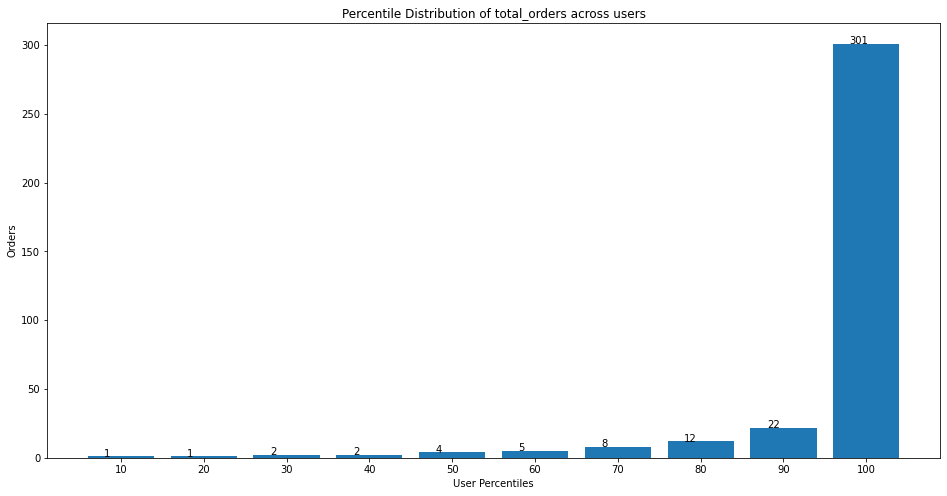

In [6]:
order_distribution_across_users(df)

### Percentile Distribution of total_orders in 4 months across users

> As can be seen from the plot above, 80% of the users have order below 12 in the last 4 months. 
Most of the heavy & active users fall in the top 10 percentile bucket.
Broadly we will be dividing the users in 3 buckets


1.   Top 10 Percentile bucket - This bucket has users with orders more than 22. These are the most active and heavu users
2.   Middle Bucket (80-90 percentile bucket) - This bucket has users with orders less 22 but more than 12
3.   Bottom 80 (0-80 percentile bucket) - This bucket has users with order less than 12

> After the broad categorization, we will further analyze the weekly pattern of orders for each user, to form a hypothesis for churn prediction. For this, we will calculate the number of orders at weekly level.

**Point to be noted** <br>
Till now, we have not used "purchase value" feature, we are only analyzing number of orders, user has placed









In [7]:
## Getting the week for each timestamp to analyse the weekly pattern
df["week"] = df.timestamp.apply(lambda x: pd.Timestamp(x).week)
## Removing the last week, as it could be incomplete
df = df[df["week"]!=df.week.max()].reset_index(drop=True)

print("Number of weeks in the data : {}".format(df.week.max()-df.week.min()))
print("Min Week: {}".format(df.week.min()))
print("Max Week: {}".format(df.week.max()))

Number of weeks in the data : 16
Min Week: 33
Max Week: 49


In [8]:
## Getting the total orders
df_total_orders = df.pivot_table(index = 'user_id', values=['timestamp'], aggfunc='count').reset_index()
df_total_orders = df_total_orders.rename({'timestamp': 'total_orders'}, axis=1)
df = df.merge(df_total_orders, on='user_id', how='left')

## Getting the orders at week-level
df_weekly_orders = df.pivot_table(index = ['user_id','week'], values=['timestamp','purchase_value'], 
                                  aggfunc={'timestamp':'count', 'purchase_value':'sum'}).reset_index()
df_weekly_orders = df_weekly_orders.rename({'timestamp': 'weekly_orders', 'purchase_value':'weekly_purchase_value'}, axis=1)
df = df.merge(df_weekly_orders, on=['user_id','week'], how='left')

In [9]:
df.sort_values(by=['user_id','week','timestamp'], ascending=True, inplace=True)
df

,user_id,timestamp,purchase_value,week,total_orders,weekly_purchase_value,weekly_orders
37427,0000602f168960c53835096f2daad506a80fcef2b4b13a...,2022-11-18 18:04:06.046,132.0,46,1,132.0,1
25880,0001b82c569a333a80c48f2004827e4a8e5be5840fbd9b...,2022-09-14 13:19:47.121,113.0,37,1,113.0,1
91426,000700164cee77c05439c206a588b66fe734150ede585f...,2022-08-22 01:56:48.002,260.0,34,22,395.0,2
82339,000700164cee77c05439c206a588b66fe734150ede585f...,2022-08-25 04:00:16.096,135.0,34,22,395.0,2
23357,000700164cee77c05439c206a588b66fe734150ede585f...,2022-09-13 13:43:09.296,166.0,37,22,166.0,1
...,...,...,...,...,...,...,...
145196,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,2022-12-02 09:55:45.700,347.0,48,50,667.0,2
102662,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,2022-12-05 09:05:50.965,347.0,49,50,694.0,2
107139,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,2022-12-06 07:00:33.518,347.0,49,50,694.0,2
37164,fff3dcdeb160d90148711b4144d009edbafecde079fcc5...,2022-09-18 04:50:24.521,70.0,37,1,70.0,1


### Top 10 Percentile Bucket
> These are the most active and heavy users. To predict the users vulnerable to churn, we will check if there is a decline in average weekly orders of last 4 weeks compared to second last 4 weeks. <br>
i.e. 
```
Avg(weekly orders of last 4 weeks) / Avg(weekly orders of second last 4 weeks) < threshold
```
We will set the threshold to be 0.5




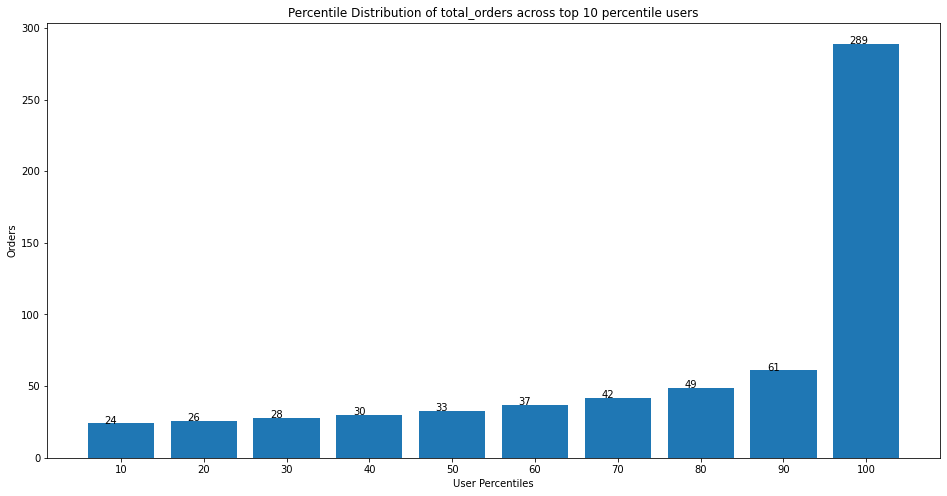

In [10]:
## Getting the top 10 percentile users based on the total_orders
## total_orders value for the 90th percentile is 22
df_top_10 = df[df["total_orders"]>22]
order_distribution_across_users(df_top_10, title="Percentile Distribution of total_orders across top 10 percentile users")

In [11]:
df_top_10_weekly = (df_top_10[["user_id","week","weekly_orders","weekly_purchase_value"]]).drop_duplicates().reset_index().drop(['index'], axis = 1)

In [12]:
df_top_10_weekly

,user_id,week,weekly_orders,weekly_purchase_value
0,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,33,4,1669.0
1,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,34,4,1569.0
2,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,35,8,4879.0
3,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,36,3,554.0
4,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,37,2,860.0
...,...,...,...,...
29872,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,45,5,861.0
29873,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,46,2,449.0
29874,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,47,2,690.0
29875,fff3dca643fdb28f6a582b46b9d44279e319296d66bf75...,48,2,667.0


In [13]:
df_top_10_weekly_last_4 = df_top_10_weekly[df_top_10_weekly["week"].isin([46,47,48,49])]
df_top_10_weekly_last_4 = df_top_10_weekly_last_4.pivot_table(index = ['user_id'], values=['weekly_orders'], aggfunc='mean').reset_index()
df_top_10_weekly_last_4 = df_top_10_weekly_last_4.rename({"weekly_orders": "last_4_weeks_avg_orders"}, axis = 1)

df_top_10_weekly_second_last_4 = df_top_10_weekly[df_top_10_weekly["week"].isin([42,43,44,45])]
df_top_10_weekly_second_last_4 = df_top_10_weekly_second_last_4.pivot_table(index = ['user_id'], values=['weekly_orders'], aggfunc='mean').reset_index()
df_top_10_weekly_second_last_4 = df_top_10_weekly_second_last_4.rename({"weekly_orders": "second_last_4_weeks_avg_orders"}, axis = 1)


df_top_10_users = df_top_10_weekly[["user_id"]].drop_duplicates().reset_index().drop(["index"], axis = 1)
df_top_10_users = df_top_10_users.merge(df_top_10_weekly_last_4, on="user_id", how="left")
df_top_10_users = df_top_10_users.merge(df_top_10_weekly_second_last_4, on="user_id", how="left")
df_top_10_users = df_top_10_users.fillna(0.1)
df_top_10_users["ratio"] = df_top_10_users["last_4_weeks_avg_orders"]/df_top_10_users["second_last_4_weeks_avg_orders"]


In [14]:
users_churn_top_10_1 = list((df_top_10_users[(df_top_10_users["last_4_weeks_avg_orders"]==0.1) 
                          & (df_top_10_users["second_last_4_weeks_avg_orders"]==0.1)]).user_id.values)
users_churn_top_10_2 = list((df_top_10_users[df_top_10_users["ratio"] < 0.5]).user_id.values)

users_churn_top_10 = users_churn_top_10_1 + users_churn_top_10_2

In [15]:
print("Number of users vulnerable to churn in top 10 percentile bucket: {}".format(len(users_churn_top_10)))

Number of users vulnerable to churn in top 10 percentile bucket: 177


#### Customer Life Time Value of the Top 10 percentile of Users
> Customer Lifetime Value can be calculated by multiplying your customer's average purchase value, average purchase frequency, and average customer lifespan. <br>

```
LTV = Average(Weekly purchase value) * LifeSpan
```
> LifeSpan of the top users are assumed to 1 year for now




In [16]:
df_top_10_ltv = df_top_10_weekly.pivot_table(index = ['user_id'], values=['weekly_purchase_value'], aggfunc='mean').reset_index()
df_top_10_ltv['ltv'] = df_top_10_ltv['weekly_purchase_value']*52

In [17]:
df_top_10_ltv

,user_id,weekly_purchase_value,ltv
0,00276702d3dfe405faae5865d69f7591f17cfb3b4911a4...,1258.470588,65440.470588
1,002ad2a1aca7752b884a129e7b221fbd517fd045ff16cd...,827.909091,43051.272727
2,0055584dd920f8978d76dee28f986668e1aa8da1607d2c...,850.928571,44248.285714
3,0088e80c4d74fc3b3da9cd3339cccd3018c1a57846cc04...,773.307692,40212.000000
4,009f92b72ebe5d362e4cfdf39cfb19aa3b99290dfc4114...,1071.866667,55737.066667
...,...,...,...
2170,ff9ce209107c70a5433d1a50ece5577396c8944481c067...,654.272727,34022.181818
2171,ffc9bd2df9704e70f56514556fccafbc229d4692fd7be8...,944.250000,49101.000000
2172,ffed5568a5334f55e81a298a1ddf860790ba7016e293bb...,964.083333,50132.333333
2173,ffed85184c78f3281cef7f03f45f4d79922d78c57ebb2f...,1118.312500,58152.250000


### Middle Bucket (80-90 percentile bucket)
> These are believed to be the consistent users. To predict the users vulnerable to churn, we will again check if there is a decline in average weekly orders of last 4 weeks compared to second last 4 weeks. <br>
i.e. 
```
Avg(weekly orders of last 4 weeks) / Avg(weekly orders of second last 4 weeks) < threshold
```
We will set the threshold to be 0.5

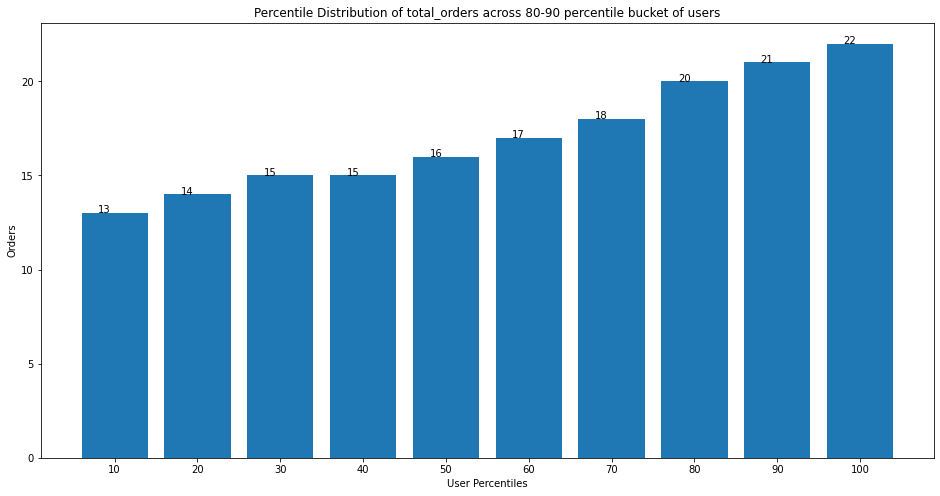

In [18]:
df_middle = df[df["total_orders"].isin(range(13,23))]
order_distribution_across_users(df_middle, title = "Percentile Distribution of total_orders across 80-90 percentile bucket of users")

In [19]:
df_middle_weekly = (df_middle[["user_id","week","weekly_orders"]]).drop_duplicates().reset_index().drop(['index'], axis = 1)

In [20]:
df_middle_weekly_last_4 = df_middle_weekly[df_middle_weekly["week"].isin([46,47,48,49])]
df_middle_weekly_last_4 = df_middle_weekly_last_4.pivot_table(index = ['user_id'], values=['weekly_orders'], aggfunc='mean').reset_index()
df_middle_weekly_last_4 = df_middle_weekly_last_4.rename({"weekly_orders": "last_4_weeks_avg_orders"}, axis = 1)

df_middle_weekly_second_last_4 = df_middle_weekly[df_middle_weekly["week"].isin([42,43,44,45])]
df_middle_weekly_second_last_4 = df_middle_weekly_second_last_4.pivot_table(index = ['user_id'], values=['weekly_orders'], aggfunc='mean').reset_index()
df_middle_weekly_second_last_4 = df_middle_weekly_second_last_4.rename({"weekly_orders": "second_last_4_weeks_avg_orders"}, axis = 1)


df_middle_users = df_middle_weekly[["user_id"]].drop_duplicates().reset_index().drop(["index"], axis = 1)
df_middle_users = df_middle_users.merge(df_middle_weekly_last_4, on="user_id", how="left")
df_middle_users = df_middle_users.merge(df_middle_weekly_second_last_4, on="user_id", how="left")
df_middle_users = df_middle_users.fillna(0.1)
df_middle_users["ratio"] = df_middle_users["last_4_weeks_avg_orders"]/df_middle_users["second_last_4_weeks_avg_orders"]


In [21]:
users_churn_middle_1 = list((df_middle_users[(df_middle_users["last_4_weeks_avg_orders"]==0.1) 
                          & (df_middle_users["second_last_4_weeks_avg_orders"]==0.1)]).user_id.values)
users_churn_middle_2 = list((df_middle_users[df_middle_users["ratio"] < 0.5]).user_id.values)

users_churn_middle = users_churn_middle_1 + users_churn_middle_2

In [22]:
print("Number of users vulnerable to churn in the 80-90 percentile bucket: {}".format(len(users_churn_middle)))

Number of users vulnerable to churn in the 80-90 percentile bucket: 282


### Bottom 80 (0-80 percentile bucket)
> This mostly comprises of New Users, Light Users and Inactive users.

1.   New users are those, who have made purchases first time in the last 8 weeks. New users are always vulnerable to churn.
2.   Inactive users are assumed to be, who have not made any purchases in the last 8 weeks.
3.   Rest of the users can be considered as light users




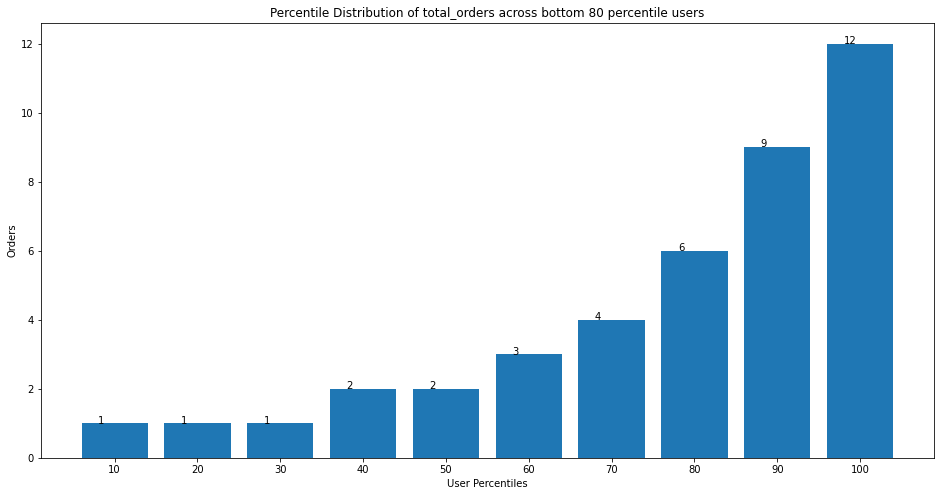

In [23]:
df_bottom_80 = df[df["total_orders"] <= 12]
order_distribution_across_users(df_bottom_80, title = "Percentile Distribution of total_orders across bottom 80 percentile users")

Number of new users are: 6146
 



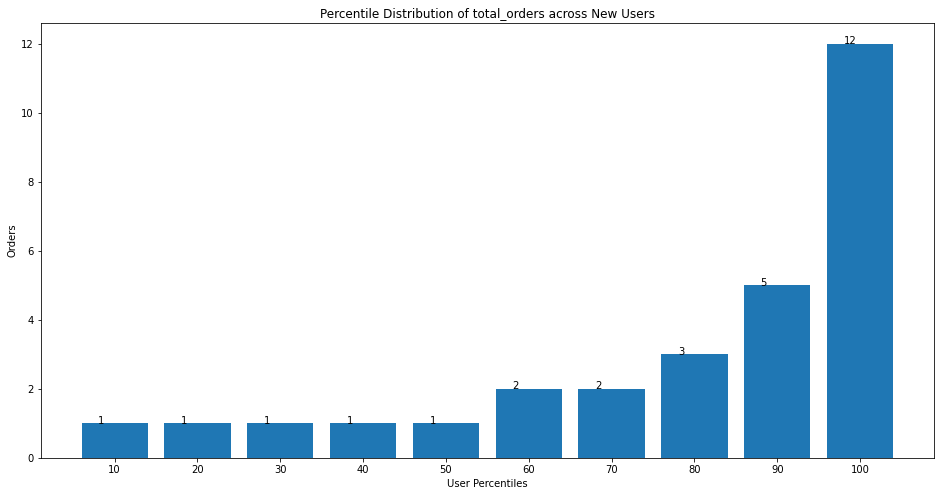

In [24]:
## get new user
## new users are those, who have made first purchase in the last 8 weeks
df_bottom_80_new = df_bottom_80.groupby('user_id').apply(lambda x: x.iloc[0]).reset_index(drop=True)
df_bottom_80_new = df_bottom_80_new[df_bottom_80_new["week"].isin([42,43,44,45,46,47,48,49])].reset_index(drop=True)

new_users = list(df_bottom_80_new.user_id.values)
print("Number of new users are: {}\n \n".format(len(new_users)))

df_bottom_80_new_users = df_bottom_80[df_bottom_80["user_id"].isin(new_users)].reset_index(drop=True)
order_distribution_across_users(df_bottom_80_new_users, title = "Percentile Distribution of total_orders across New Users")

Number of inactive users are: 5281


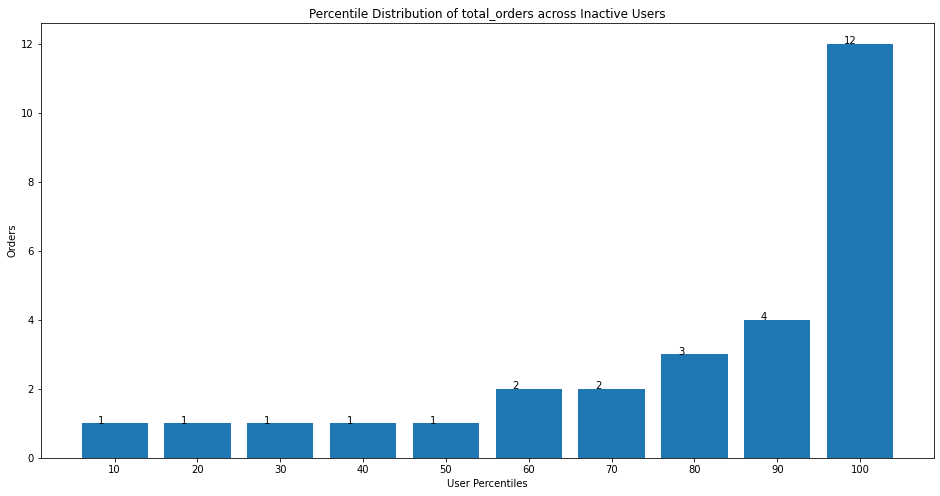

In [25]:
## get inactive users
## inactive users are those, who have not made any purchase in the last 8 weeks
df_bottom_80_inactive = df_bottom_80.groupby('user_id').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
df_bottom_80_inactive = df_bottom_80_inactive[df_bottom_80_inactive["week"] < 42].reset_index(drop=True)

inactive_users = list(df_bottom_80_inactive.user_id.values)
print("Number of inactive users are: {}".format(len(inactive_users)))

df_bottom_80_inactive_users = df_bottom_80[df_bottom_80["user_id"].isin(inactive_users)].reset_index(drop=True)
order_distribution_across_users(df_bottom_80_inactive_users, title = "Percentile Distribution of total_orders across Inactive Users")

Number of light users are: 7467


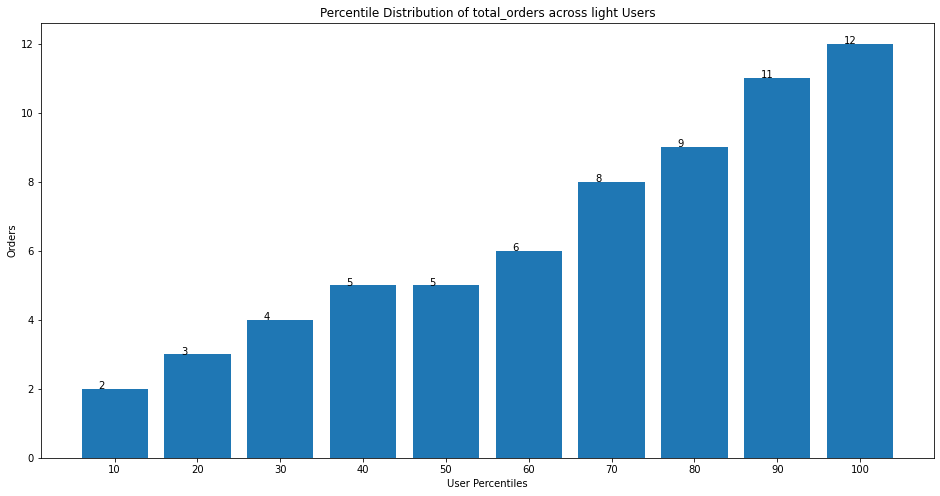

In [26]:
## light users
df_bottom_80_light_users = df_bottom_80[~df_bottom_80["user_id"].isin(new_users+inactive_users)].reset_index(drop=True)

light_users = list(df_bottom_80_light_users.user_id.unique())
print("Number of light users are: {}".format(len(light_users)))

order_distribution_across_users(df_bottom_80_light_users, title = "Percentile Distribution of total_orders across light Users")